# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [182]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [183]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 17, 9, 37, 8971)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [184]:
project = hopsworks.login(project="id2223_lab1_group9")
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164442
Connected. Call `.close()` to terminate connection gracefully.
API Key: ZdlnIknsr9JP3yFH.x9eD8jZiaKdhtr713oZflp5VN9dOkv4upr3ZDi8WYF2kRi0rLdGEJ8HHCasb3wKs
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [185]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=2,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [186]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [187]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.0609045E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [188]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=4,
)
# batch_data = weather_fg.filter(weather_fg.date >= today).read()
# batch_data

In [189]:
batch_data = weather_fg.filter(weather_fg.date >= today).read()
air_quality_fg_df = air_quality_fg.read()

historical_pm25 = air_quality_fg_df[['date', 'pm25']]
historical_pm25 = historical_pm25.sort_values(by='date')
historical_pm25 = historical_pm25.tail(3)

def calculate_pm25_lagging_3_days(pm25_series):
    return pm25_series.rolling(window=3).mean()

batch_data['predicted_pm25'] = None

# Iterate over each day in batch_data to predict PM2.5
for i in range(len(batch_data)):
    current_date = batch_data.iloc[i]['date']
    current_weather_features = batch_data.iloc[i][['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    # Get the historical PM2.5 values for the previous 3 days
    historical_pm25_values = historical_pm25[historical_pm25['date'] < current_date]['pm25'].tolist()
    predicted_pm25_values = batch_data[batch_data['date'] < current_date]['predicted_pm25'].tolist()

    # Combine historical and predicted PM2.5 values
    pm25_values = historical_pm25_values + predicted_pm25_values
    pm25_values = [value for value in pm25_values if value is not None]

    # Calculate the lagged PM2.5 feature
    if len(pm25_values) >= 3:
        pm25_lagging_3_days = calculate_pm25_lagging_3_days(pd.Series(pm25_values)).iloc[-1]
    else:
        pm25_lagging_3_days = None

    # If we have enough data to calculate the lagged feature, make a prediction
    if pm25_lagging_3_days is not None:
        features = current_weather_features.tolist() + [pm25_lagging_3_days]
        predicted_pm25 = retrieved_xgboost_model.predict([features])[0]
        batch_data.at[i, 'pm25_lagging_3_days'] = pm25_lagging_3_days
        batch_data.at[i, 'predicted_pm25'] = predicted_pm25

batch_data['pm25_lagging_3_days'] = batch_data['pm25_lagging_3_days'].astype('float32')
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagging_3_days
0,2024-11-21 00:00:00+00:00,-2.20,0.2,28.585449,301.087433,stockholm,1.6638,3.476667
1,2024-11-27 00:00:00+00:00,1.60,0.0,9.659814,296.564972,stockholm,7.039985,3.804600
2,2024-11-22 00:00:00+00:00,-4.95,0.0,11.918120,295.016846,stockholm,2.823304,3.804600
3,2024-11-28 00:00:00+00:00,2.85,0.0,16.199999,233.130020,stockholm,3.289817,3.842363
4,2024-11-24 00:00:00+00:00,0.30,0.0,8.891343,148.240570,stockholm,3.187031,4.495701
5,2024-11-23 00:00:00+00:00,-4.10,0.0,12.904882,292.988739,stockholm,2.823304,4.495701
6,2024-11-25 00:00:00+00:00,5.60,0.0,15.807239,210.068497,stockholm,3.186746,2.944546
7,2024-11-26 00:00:00+00:00,7.90,0.0,22.183128,221.710663,stockholm,4.078051,3.065694
8,2024-11-20 00:00:00+00:00,1.05,0.4,19.959719,352.746887,stockholm,1.472989,3.476667


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [190]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['pm25_lagging_3_days', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagging_3_days
0,2024-11-21 00:00:00+00:00,-2.20,0.2,28.585449,301.087433,stockholm,1.242056,3.476667
1,2024-11-27 00:00:00+00:00,1.60,0.0,9.659814,296.564972,stockholm,2.899976,3.804600
2,2024-11-22 00:00:00+00:00,-4.95,0.0,11.918120,295.016846,stockholm,1.374999,3.804600
3,2024-11-28 00:00:00+00:00,2.85,0.0,16.199999,233.130020,stockholm,8.859696,3.842363
4,2024-11-24 00:00:00+00:00,0.30,0.0,8.891343,148.240570,stockholm,12.984085,4.495701
5,2024-11-23 00:00:00+00:00,-4.10,0.0,12.904882,292.988739,stockholm,2.096447,4.495701
6,2024-11-25 00:00:00+00:00,5.60,0.0,15.807239,210.068497,stockholm,5.311609,2.944546
7,2024-11-26 00:00:00+00:00,7.90,0.0,22.183128,221.710663,stockholm,2.180092,3.065694
8,2024-11-20 00:00:00+00:00,1.05,0.4,19.959719,352.746887,stockholm,0.692984,3.476667


In [191]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   pm25_lagging_3_days          9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(6), object(1)
memory usage: 492.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [192]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagging_3_days,street,country,days_before_forecast_day
8,2024-11-20 00:00:00+00:00,1.05,0.4,19.959719,352.746887,stockholm,0.692984,3.476667,stockholm-anders-lundstroms-gata,sweden,9
0,2024-11-21 00:00:00+00:00,-2.20,0.2,28.585449,301.087433,stockholm,1.242056,3.476667,stockholm-anders-lundstroms-gata,sweden,1
2,2024-11-22 00:00:00+00:00,-4.95,0.0,11.918120,295.016846,stockholm,1.374999,3.804600,stockholm-anders-lundstroms-gata,sweden,3
5,2024-11-23 00:00:00+00:00,-4.10,0.0,12.904882,292.988739,stockholm,2.096447,4.495701,stockholm-anders-lundstroms-gata,sweden,6
4,2024-11-24 00:00:00+00:00,0.30,0.0,8.891343,148.240570,stockholm,12.984085,4.495701,stockholm-anders-lundstroms-gata,sweden,5
6,2024-11-25 00:00:00+00:00,5.60,0.0,15.807239,210.068497,stockholm,5.311609,2.944546,stockholm-anders-lundstroms-gata,sweden,7
7,2024-11-26 00:00:00+00:00,7.90,0.0,22.183128,221.710663,stockholm,2.180092,3.065694,stockholm-anders-lundstroms-gata,sweden,8
1,2024-11-27 00:00:00+00:00,1.60,0.0,9.659814,296.564972,stockholm,2.899976,3.804600,stockholm-anders-lundstroms-gata,sweden,2
3,2024-11-28 00:00:00+00:00,2.85,0.0,16.199999,233.130020,stockholm,8.859696,3.842363,stockholm-anders-lundstroms-gata,sweden,4


In [193]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 8 to 3
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   pm25_lagging_3_days          9 non-null      float32            
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64         

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

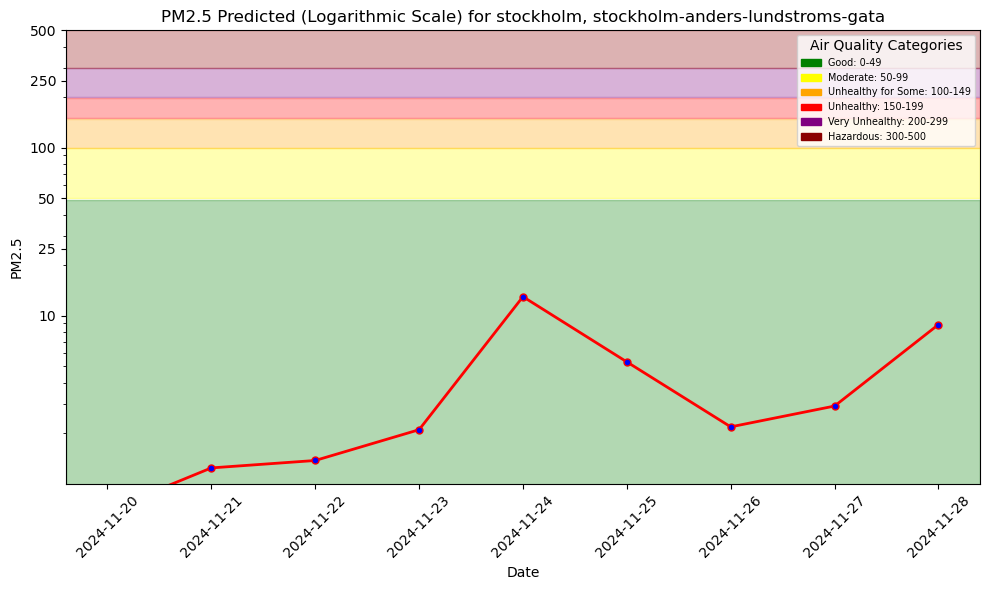

In [194]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [195]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=6,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [196]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1164442/fs/1155145/fg/1358166
2024-11-19 17:09:54,324 WARNING: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_6_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1164442/jobs/named/aq_predictions_6_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x3076e8ed0>, None)

In [197]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagging_3_days,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,-2.2,0.2,28.585449,301.087433,stockholm,1.242056,3.476667,stockholm-anders-lundstroms-gata,sweden,1


In [198]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=4,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,date,pm25,pm25_lagging_3_days,country,city,street,url
0,2021-11-09 00:00:00+00:00,1.60,1.043333,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1,2020-12-22 00:00:00+00:00,4.83,9.346666,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
2,2022-07-25 00:00:00+00:00,3.40,3.046667,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
3,2023-06-07 00:00:00+00:00,0.80,1.183333,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
4,2021-09-05 00:00:00+00:00,1.26,1.223333,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
...,...,...,...,...,...,...,...
1783,2023-03-21 00:00:00+00:00,3.07,11.550000,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1784,2023-02-01 00:00:00+00:00,2.13,0.860000,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1785,2020-01-20 00:00:00+00:00,1.35,6.333333,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420
1786,2021-09-15 00:00:00+00:00,0.90,3.066667,sweden,stockholm,stockholm-anders-lundstroms-gata,https://api.waqi.info/feed/A61420


In [199]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    features_df = air_quality_fg.select(['pm25_lagging_3_days']).join(weather_fg.select_all(), on=['city']).read()
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)
    features_df['predicted_pm25'] = retrieved_xgboost_model.predict(features_df[['pm25_lagging_3_days', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    df = pd.merge(features_df, air_quality_df[['date','pm25','street','country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 
2024-11-19 17:11:30,990 WARNING: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_6_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1164442/jobs/named/aq_predictions_6_offline_fg_materialization/executions


,pm25_lagging_3_days,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2.586667,2024-11-10 00:00:00+00:00,5.334500,0.0,9.102021,139.972229,stockholm,7.080892,1.40,stockholm-anders-lundstroms-gata,sweden,1
1,2.760000,2024-11-11 00:00:00+00:00,4.776166,2.7,10.028439,236.030014,stockholm,6.218450,2.50,stockholm-anders-lundstroms-gata,sweden,1
2,2.926667,2024-11-12 00:00:00+00:00,2.790750,0.0,10.196647,286.209778,stockholm,2.978300,0.90,stockholm-anders-lundstroms-gata,sweden,1
3,1.600000,2024-11-13 00:00:00+00:00,3.603250,0.0,15.156384,239.627930,stockholm,2.097659,1.80,stockholm-anders-lundstroms-gata,sweden,1
4,1.733333,2024-11-14 00:00:00+00:00,4.484500,0.0,18.000898,296.312195,stockholm,1.067880,1.67,stockholm-anders-lundstroms-gata,sweden,1
5,1.456667,2024-11-15 00:00:00+00:00,5.978251,0.0,23.623928,256.343628,stockholm,1.802120,1.48,stockholm-anders-lundstroms-gata,sweden,1
6,1.650000,2024-11-16 00:00:00+00:00,7.809501,0.1,27.615191,244.305389,stockholm,1.791463,1.08,stockholm-anders-lundstroms-gata,sweden,1
7,1.410000,2024-11-17 00:00:00+00:00,4.847000,0.0,23.623928,255.876282,stockholm,2.962013,0.68,stockholm-anders-lundstroms-gata,sweden,1
8,1.080000,2024-11-17 00:00:00+00:00,4.847000,0.0,23.623928,255.876282,stockholm,1.825924,0.68,stockholm-anders-lundstroms-gata,sweden,1
9,1.080000,2024-11-19 00:00:00+00:00,0.350000,0.0,3.976330,84.805664,stockholm,2.094287,9.00,stockholm-anders-lundstroms-gata,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

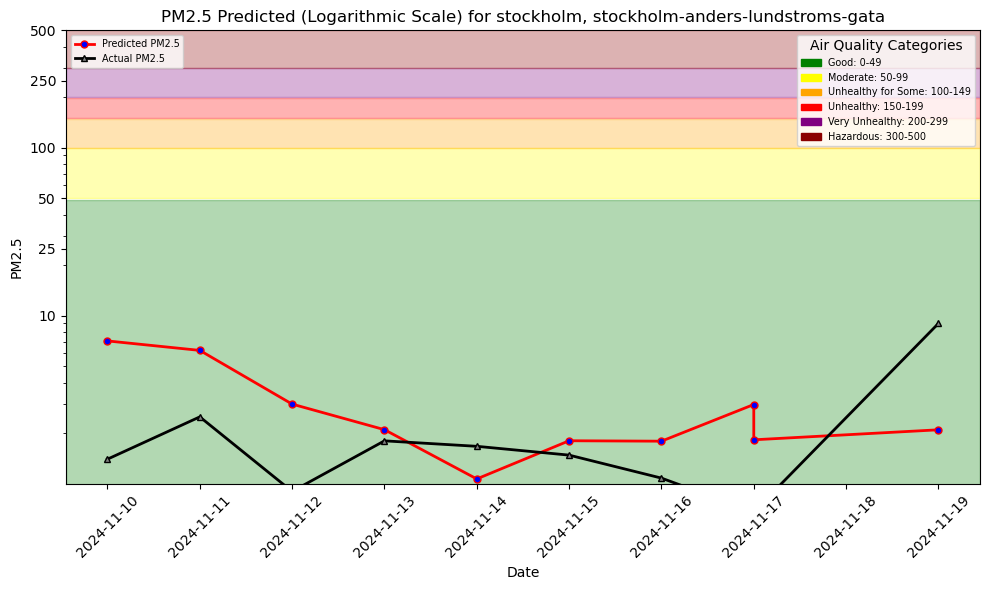

In [200]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---